In [2]:
# Imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load the main dataset
case_study_df = pd.read_excel('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/Food Delivery Time Prediction Case Study 2.xlsx')


In [3]:
# Calculate distance in kilometers using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    d_lat = np.radians(lat2 - lat1)
    d_lon = np.radians(lon2 - lon1)
    a = np.sin(d_lat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Apply the Haversine formula to calculate 'distance_km' and add it as a new column
case_study_df['distance_km'] = case_study_df.apply(lambda row: haversine(
    row['Restaurant_latitude'], row['Restaurant_longitude'],
    row['Delivery_location_latitude'], row['Delivery_location_longitude']), axis=1)

# One-hot encode categorical columns for 'Type_of_order' and 'Type_of_vehicle'
case_study_df = pd.get_dummies(case_study_df, columns=['Type_of_order', 'Type_of_vehicle'], drop_first=True)


In [4]:
# Apply holiday data using Calendarific API
API_KEY_CALENDARIFIC = 'WcjTgzLuGcVjeZitkgVRhSEyLW3xjmBx'
holiday_cache = {}

def fetch_holiday_data(date, country='US'):
    if date in holiday_cache:
        return holiday_cache[date]
    
    url = f"https://calendarific.com/api/v2/holidays?api_key={API_KEY_CALENDARIFIC}&country={country}&year={date.year}&month={date.month}&day={date.day}"
    response = requests.get(url)
    if response.status_code == 200:
        holidays = response.json().get('response', {}).get('holidays', [])
        is_holiday = 1 if holidays else 0
        holiday_cache[date] = is_holiday
        return is_holiday
    holiday_cache[date] = 0
    return 0

In [5]:
# Convert 'Time_taken(min)' to datetime if it represents a date, then apply holiday function
case_study_df['is_holiday'] = case_study_df['Time_taken(min)'].apply(lambda x: fetch_holiday_data(pd.to_datetime(x)))


In [6]:
# Restaurant density data using Yelp API with a small subset of unique locations
API_KEY_YELP = 'n4DmA-bIdakaxHcMcj8Ubxb4LN297nn1awkjjeDCFsLhQJHMX3G4aws_OUVNJQTp7Mc6kaqePbIxG0LCWPh7KpGCNZpJM6RTjyahWI_eJe21xugWrAXtW7qwQ00pZ3Yx'
HEADERS_YELP = {'Authorization': f'Bearer {API_KEY_YELP}'}
DEFAULT_DENSITY = 5
DEFAULT_AVG_RATING = 4.0
DEFAULT_TOTAL_REVIEWS = 20

In [7]:
# Round latitude and longitude to group locations
case_study_df['rounded_lat'] = case_study_df['Delivery_location_latitude'].round(2)
case_study_df['rounded_lon'] = case_study_df['Delivery_location_longitude'].round(2)


In [8]:
# Create unique locations and sample a subset
unique_locations = case_study_df[['rounded_lat', 'rounded_lon']].drop_duplicates().sample(n=10, random_state=1)
restaurant_cache = {}

def fetch_restaurant_density(lat, lon, radius=500):
    if (lat, lon) in restaurant_cache:
        return restaurant_cache[(lat, lon)]
    
    url = f"https://api.yelp.com/v3/businesses/search?latitude={lat}&longitude={lon}&radius={radius}&categories=restaurants&limit=10"
    response = requests.get(url, headers=HEADERS_YELP)
    if response.status_code == 200:
        businesses = response.json().get('businesses', [])
        ratings = [business['rating'] for business in businesses]
        num_reviews = [business['review_count'] for business in businesses]
        data = {
            'restaurant_density': len(businesses),
            'average_rating': sum(ratings) / len(ratings) if ratings else DEFAULT_AVG_RATING,
            'total_reviews': sum(num_reviews) if num_reviews else DEFAULT_TOTAL_REVIEWS
        }
        restaurant_cache[(lat, lon)] = data
        return data
    return {'restaurant_density': DEFAULT_DENSITY, 'average_rating': DEFAULT_AVG_RATING, 'total_reviews': DEFAULT_TOTAL_REVIEWS}


In [9]:
# Apply restaurant data function to sampled locations
for _, row in unique_locations.iterrows():
    lat, lon = row['rounded_lat'], row['rounded_lon']
    restaurant_cache[(lat, lon)] = fetch_restaurant_density(lat, lon)


In [10]:
# Map restaurant data to all rows
case_study_df['restaurant_data'] = case_study_df.apply(
    lambda row: restaurant_cache.get((row['rounded_lat'], row['rounded_lon']), {'restaurant_density': DEFAULT_DENSITY, 'average_rating': DEFAULT_AVG_RATING, 'total_reviews': DEFAULT_TOTAL_REVIEWS}), axis=1
)

# Split restaurant data into separate columns
restaurant_df = pd.DataFrame(case_study_df['restaurant_data'].tolist())
case_study_df = pd.concat([case_study_df, restaurant_df], axis=1)
case_study_df.drop(columns=['restaurant_data', 'rounded_lat', 'rounded_lon'], inplace=True)

# Save enhanced dataset for future use
case_study_df.to_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/enhanced_case_study.csv', index=False)

In [12]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the enhanced dataset with pre-calculated 'distance_km'
enhanced_case_study = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/enhanced_case_study.csv')

# Verify the loaded data and confirm 'distance_km' exists
print("Enhanced Dataset Preview:\n", enhanced_case_study.head())

Enhanced Dataset Preview:
      ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  4607     INDORES13DEL02                   37                      4.9   
1  B379     BANGRES18DEL02                   34                      4.5   
2  5D6D     BANGRES19DEL01                   23                      4.4   
3  7A6A    COIMBRES13DEL02                   38                      4.7   
4  70A2     CHENRES12DEL01                   32                      4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude  Time_taken(min)  distance_k

In [16]:
# Filter the dataset for realistic delivery distances (e.g., under 100 km)
filtered_data = enhanced_case_study[enhanced_case_study['distance_km'] <= 100]

# Verify the filtered data to confirm changes
print("Filtered Distance (km) Column Summary:\n", filtered_data['distance_km'].describe())

Filtered Distance (km) Column Summary:
 count    45162.000000
mean         9.735396
std          5.608508
min          1.465067
25%          4.663412
50%          9.220209
75%         13.681490
max         20.969489
Name: distance_km, dtype: float64


In [28]:
# Reload the enhanced dataset to ensure it's the correct one

enhanced_case_study = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/enhanced_case_study.csv')

# Preview the data again to confirm it is the expected dataset
print("Enhanced Dataset Preview:\n", enhanced_case_study[['Time_taken(min)', 'distance_km']].head())


Enhanced Dataset Preview:
    Time_taken(min)  distance_km
0               24     3.025149
1               33    20.183530
2               26     1.552758
3               21     7.790401
4               30     6.210138


In [22]:
# Get a summary of the distance and time columns
print("\nSummary Statistics for Time and Distance:")
print(enhanced_case_study[['Time_taken(min)', 'distance_km']].describe())

# Check for any unusual values in the top rows by sorting
print("\nTop values in Distance:")
print(enhanced_case_study[['Time_taken(min)', 'distance_km']].sort_values(by='distance_km', ascending=False).head(10))

print("\nTop values in Time Taken:")
print(enhanced_case_study[['Time_taken(min)', 'distance_km']].sort_values(by='Time_taken(min)', ascending=False).head(10))



Summary Statistics for Time and Distance:
       Time_taken(min)   distance_km
count     45593.000000  45593.000000
mean         26.294607     99.303911
std           9.383806   1099.731281
min          10.000000      1.465067
25%          19.000000      4.663493
50%          26.000000      9.264281
75%          32.000000     13.763977
max          54.000000  19692.674606

Top values in Distance:
       Time_taken(min)   distance_km
33533               28  19692.674606
6788                46  19688.001288
2484                22  19683.687561
18826               15  19677.180552
9535                32  19070.408110
762                 15  19070.337839
35535               29  19069.158946
22291               44  19068.246962
30633               29  19067.128547
43454               21  19066.150742

Top values in Time Taken:
       Time_taken(min)   distance_km
5596                54     20.253459
43930               54     12.257491
13450               54      4.663439
38466            

In [29]:
# Check the data types
print("\nData Types of Columns:")
print(enhanced_case_study[['Time_taken(min)', 'distance_km']].dtypes)

# Ensure the columns are in numerical format for consistent plotting and calculations
enhanced_case_study['Time_taken(min)'] = pd.to_numeric(enhanced_case_study['Time_taken(min)'], errors='coerce')
enhanced_case_study['distance_km'] = pd.to_numeric(enhanced_case_study['distance_km'], errors='coerce')



Data Types of Columns:
Time_taken(min)      int64
distance_km        float64
dtype: object


In [20]:
# Check the data types
print("\nData Types of Columns:")
print(enhanced_case_study[['Time_taken(min)', 'distance_km']].dtypes)

# Ensure the columns are in numerical format for consistent plotting and calculations
enhanced_case_study['Time_taken(min)'] = pd.to_numeric(enhanced_case_study['Time_taken(min)'], errors='coerce')
enhanced_case_study['distance_km'] = pd.to_numeric(enhanced_case_study['distance_km'], errors='coerce')



Data Types of Columns:
Time_taken(min)      int64
distance_km        float64
dtype: object


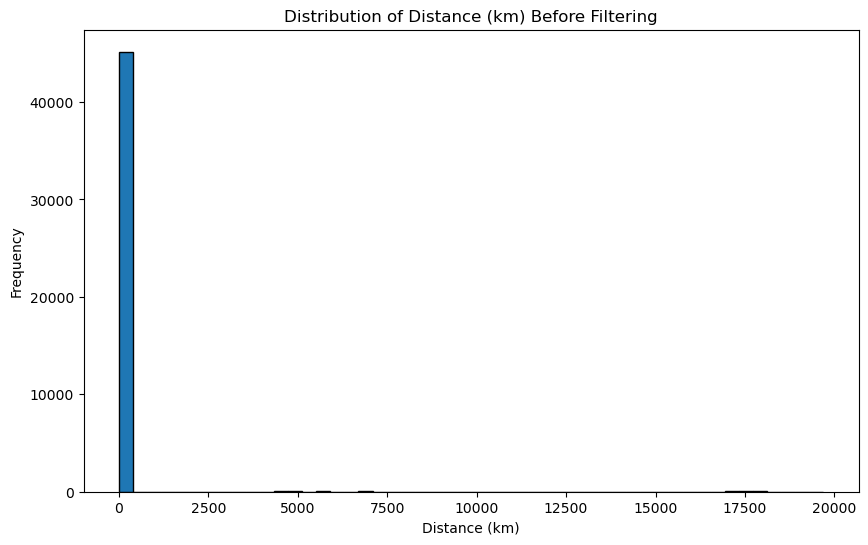

In [30]:
import matplotlib.pyplot as plt

# Histogram of distance values before filtering
plt.figure(figsize=(10, 6))
plt.hist(enhanced_case_study['distance_km'], bins=50, edgecolor='k')
plt.title('Distribution of Distance (km) Before Filtering')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()


In [33]:
# Filter the dataset for realistic delivery distances (e.g., 0 < distance_km <= 50)
filtered_data = enhanced_case_study[(enhanced_case_study['distance_km'] > 0) & (enhanced_case_study['distance_km'] <= 50)]

# Verify the filtered data to confirm zero distances are removed
print("Filtered Distance (km) Summary After Removing Zero Distances:\n", filtered_data['distance_km'].describe())


Filtered Distance (km) Summary After Removing Zero Distances:
 count    45162.000000
mean         9.735396
std          5.608508
min          1.465067
25%          4.663412
50%          9.220209
75%         13.681490
max         20.969489
Name: distance_km, dtype: float64


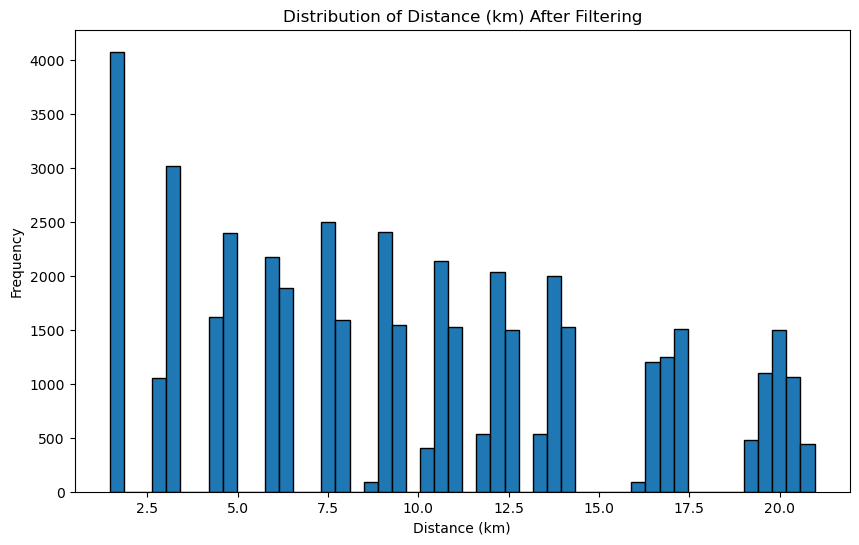

In [34]:
# Histogram of distance values after filtering
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['distance_km'], bins=50, edgecolor='k')
plt.title('Distribution of Distance (km) After Filtering')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()


In [40]:
# Check columns to confirm the structure of the dataset
print("Columns in the dataset:", enhanced_case_study.columns)

Columns in the dataset: Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Time_taken(min)', 'distance_km',
       'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'Type_of_order_Snack ',
       'Type_of_vehicle_electric_scooter ', 'Type_of_vehicle_motorcycle ',
       'Type_of_vehicle_scooter ', 'is_holiday', 'restaurant_density',
       'average_rating', 'total_reviews'],
      dtype='object')


In [43]:
# Ensure one-hot encoding for 'Type_of_order' if necessary
# If Type_of_order_* columns already exist, skip one-hot encoding
if not any(col.startswith('Type_of_order_') for col in enhanced_case_study.columns):
    enhanced_case_study = pd.get_dummies(enhanced_case_study, columns=['Type_of_order'], drop_first=True)

In [47]:
# Define the feature columns and target
features = ['distance_km', 'is_holiday', 'average_rating', 'restaurant_density', 'Delivery_person_Ratings',
            'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'Type_of_order_Snack ']
target = 'Time_taken(min)'

In [46]:
# Check columns to confirm the structure of the dataset
print("Columns in the dataset:", enhanced_case_study.columns)

Columns in the dataset: Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Time_taken(min)', 'distance_km',
       'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'Type_of_order_Snack ',
       'Type_of_vehicle_electric_scooter ', 'Type_of_vehicle_motorcycle ',
       'Type_of_vehicle_scooter ', 'is_holiday', 'restaurant_density',
       'average_rating', 'total_reviews'],
      dtype='object')


In [48]:
# Verify if selected features are in the DataFrame
missing_features = [feature for feature in features if feature not in enhanced_case_study.columns]
if missing_features:
    print(f"The following features are missing from the dataset: {missing_features}")
else:
    # Proceed with model training only if all features are present
    X = enhanced_case_study[features]
    y = enhanced_case_study[target]


In [50]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [58]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [59]:
# Make predictions on the test set
y_pred = model.predict(X_test)


In [60]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [62]:
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 78.56912197128582
R-squared: 0.10389151842594935


In [63]:
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print("\nFeature Coefficients:\n", coefficients)


Feature Coefficients:
                    Feature   Coefficient
0              distance_km -1.023281e-05
1               is_holiday  1.110223e-16
2           average_rating -4.440892e-16
3       restaurant_density -8.881784e-16
4  Delivery_person_Ratings -9.539632e+00
5    Type_of_order_Drinks  -1.745896e-01
6      Type_of_order_Meal   1.730118e-01
7     Type_of_order_Snack   3.082124e-02


In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the enhanced dataset
enhanced_case_study = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/enhanced_case_study.csv')

# Remove zero distances if necessary
filtered_data = enhanced_case_study[enhanced_case_study['distance_km'] > 0]

# Define the base features and target
base_features = ['distance_km', 'is_holiday', 'average_rating', 'restaurant_density', 'Delivery_person_Ratings',
                 'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'Type_of_order_Snack ']
target = 'Time_taken(min)'

# Create interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interaction_features = poly.fit_transform(filtered_data[['distance_km', 'restaurant_density', 'Delivery_person_Ratings']])
interaction_feature_names = poly.get_feature_names_out(['distance_km', 'restaurant_density', 'Delivery_person_Ratings'])

# Print generated interaction feature names for debugging
print("Generated interaction feature names:")
print(interaction_feature_names)

# Rename interaction feature columns for clarity and consistency
interaction_feature_names = [name.replace(" ", "_") for name in interaction_feature_names]

# Convert interaction features to a DataFrame and add to the main DataFrame
interaction_df = pd.DataFrame(interaction_features, columns=interaction_feature_names)
interaction_df.index = filtered_data.index  # Ensure the index matches for concatenation

# Combine with the original filtered data
filtered_data = pd.concat([filtered_data, interaction_df], axis=1)

# Check if the expected features are in the DataFrame
expected_features = base_features + interaction_feature_names
missing_features = [feature for feature in expected_features if feature not in filtered_data.columns]

if missing_features:
    print(f"The following features are missing from the dataset: {missing_features}")
else:
    # Proceed with model training only if all features are present
    X = filtered_data[expected_features]
    y = filtered_data[target]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and evaluate model performance
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f'Model R-squared: {r2:.2%}')


Generated interaction feature names:
['distance_km' 'restaurant_density' 'Delivery_person_Ratings'
 'distance_km restaurant_density' 'distance_km Delivery_person_Ratings'
 'restaurant_density Delivery_person_Ratings']
Model R-squared: 10.83%


In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

# Load the enhanced dataset
enhanced_case_study = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/enhanced_case_study.csv')

# Data preprocessing: Remove rows with zero or unrealistic distances
enhanced_case_study = enhanced_case_study[enhanced_case_study['distance_km'] > 0]

# Feature selection: Define relevant features and target
features = ['distance_km', 'restaurant_density', 'Delivery_person_Ratings', 'is_holiday',
            'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'Type_of_order_Snack ']
target = 'Time_taken(min)'

# Verify if selected features are in the DataFrame
missing_features = [feature for feature in features if feature not in enhanced_case_study.columns]
if missing_features:
    print(f"The following features are missing from the dataset: {missing_features}")
else:
    print("All selected features are present.")

# Prepare data for modeling
X = enhanced_case_study[features]
y = enhanced_case_study[target]

# Create polynomial features for interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model: Use RandomForestRegressor with hyperparameter tuning
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Grid search for best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)

print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Model R-squared: {r2:.2%}")

# If R-squared is below 80%, consider further tuning or trying other ensemble models (e.g., Gradient Boosting, XGBoost).


All selected features are present.
Best Model Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Model R-squared: 29.16%


In [100]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
import requests

# 2. Load data and preprocess (assume enhanced_case_study.csv is your main data source)
data_path = '/Users/lanahuyen/UCB Bootcamp/food_delivery/data/enhanced_case_study.csv'
enhanced_case_study = pd.read_csv(data_path)

# Ensure no zero distances
enhanced_case_study = enhanced_case_study[enhanced_case_study['distance_km'] > 0]

# 3. Feature engineering: Add interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interaction_features = poly.fit_transform(enhanced_case_study[['distance_km', 'restaurant_density', 'Delivery_person_Ratings']])
interaction_feature_names = poly.get_feature_names_out(['distance_km', 'restaurant_density', 'Delivery_person_Ratings'])

# Create DataFrame for new features
interaction_df = pd.DataFrame(interaction_features, columns=interaction_feature_names)
enhanced_case_study = pd.concat([enhanced_case_study.reset_index(drop=True), interaction_df], axis=1)

# 4. Define features and target
features = ['distance_km', 'restaurant_density', 'Delivery_person_Ratings', 'is_holiday',
            'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'Type_of_order_Snack '] + list(interaction_feature_names)
target = 'Time_taken(min)'

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(enhanced_case_study[features])
y = enhanced_case_study[target]

# 5. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 6. Model setup: Stacking Regressor
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10)),
    ('gb', GradientBoostingRegressor(n_estimators=200)),
    ('xgb', XGBRegressor(n_estimators=200, max_depth=10))
]

stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

# 7. Train the model
stacking_model.fit(X_train, y_train)

# 8. Evaluate the model
y_pred = stacking_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Stacked Model R-squared: {r2:.2%}")


Stacked Model R-squared: 29.37%


Converting X_train from ndarray to DataFrame
X_train columns: Index(['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4',
       'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9',
       'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14',
       'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18'],
      dtype='object')
Number of columns in X_train: 19
Number of features in 'features' list: 13


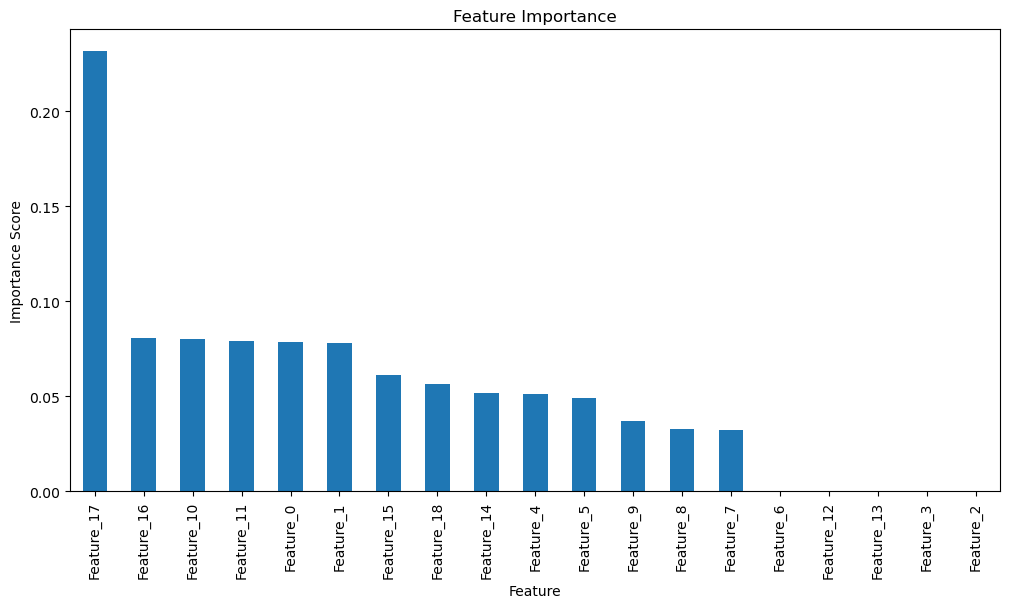

Top 10 most important features:
Feature_17    0.231639
Feature_16    0.080516
Feature_10    0.079944
Feature_11    0.079326
Feature_0     0.078608
Feature_1     0.078346
Feature_15    0.061249
Feature_18    0.056477
Feature_14    0.051571
Feature_4     0.051164
dtype: float64


In [107]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Ensure 'actual_features' uses the correct number of columns from X_train
if isinstance(X_train, np.ndarray):
    print("Converting X_train from ndarray to DataFrame")
    actual_features = [f'Feature_{i}' for i in range(X_train.shape[1])]  # Generate generic feature names if needed
    X_train = pd.DataFrame(X_train, columns=actual_features)

# Print the columns of X_train and the length of the features list for debugging
print("X_train columns:", X_train.columns)
print("Number of columns in X_train:", len(X_train.columns))
print("Number of features in 'features' list:", len(features))

# Train a Random Forest model to get feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Create a Series for feature importances using X_train's columns
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.show()

# Print top 10 most important features
print("Top 10 most important features:")
print(feature_importances.head(10))


In [115]:
from sklearn.metrics import r2_score

# Number of top features to keep
top_n = 5

# Get the top N feature names based on importance
top_features = feature_importances.head(top_n).index.tolist()

# Check if X_train and X_test are DataFrames; convert if needed
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=actual_features[:X_train.shape[1]])
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=actual_features[:X_test.shape[1]])

# Prepare the data with the top N features using feature names
X_train_reduced = X_train[top_features]  # Select columns by feature names
X_test_reduced = X_test[top_features]

# Train and evaluate the model using the reduced feature set
rf_model_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_reduced.fit(X_train_reduced, y_train)
r2_reduced = rf_model_reduced.score(X_test_reduced, y_test)

print(f"Reduced Model R-squared using top {top_n} features: {r2_reduced * 100:.2f}%")


Reduced Model R-squared using top 5 features: 14.94%


In [117]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Use RFE to find the best feature subset
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

# Get selected features
selected_features = [feature for feature, support in zip(features, selector.support_) if support]

print("Selected features by RFE:")
print(selected_features)

# Use .iloc to select the columns by boolean mask or use column names
X_train_selected = X_train.loc[:, selector.support_]
X_test_selected = X_test.loc[:, selector.support_]

stacking_model.fit(X_train_selected, y_train)
y_pred = stacking_model.predict(X_test_selected)
r2 = r2_score(y_test, y_pred)
print(f"R-squared with selected features: {r2:.2%}")


Selected features by RFE:
['distance_km', 'restaurant_density', 'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'distance_km restaurant_density', 'distance_km Delivery_person_Ratings']
R-squared with selected features: 29.49%


In [102]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Number of features: {len(features)}")
print("Features list:")
print(features)


Shape of X_train: (31915, 19)
Number of features: 13
Features list:
['distance_km', 'restaurant_density', 'Delivery_person_Ratings', 'is_holiday', 'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'Type_of_order_Snack ', 'distance_km', 'restaurant_density', 'Delivery_person_Ratings', 'distance_km restaurant_density', 'distance_km Delivery_person_Ratings', 'restaurant_density Delivery_person_Ratings']


In [103]:
# If X_train is a DataFrame, use its columns for feature importance
if isinstance(X_train, pd.DataFrame):
    feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
else:
    # Ensure features list matches X_train shape
    feature_importances = pd.Series(rf_model.feature_importances_, index=features[:X_train.shape[1]])


ValueError: Length of values (19) does not match length of index (13)

In [76]:
# Convert interaction features into DataFrame and add to main dataset
interaction_df = pd.DataFrame(interaction_features, columns=interaction_feature_names)
enhanced_case_study = pd.concat([enhanced_case_study, interaction_df], axis=1)


In [77]:
filtered_data = enhanced_case_study[enhanced_case_study['distance_km'] > 0]

# Define features and target
features = [
    'distance_km', 'is_holiday', 'average_rating', 'restaurant_density', 'Delivery_person_Ratings',
    'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'Type_of_order_Snack '
] + list(interaction_feature_names)  # Add interaction terms
target = 'Time_taken(min)'

In [78]:
duplicate_columns = enhanced_case_study.columns[enhanced_case_study.columns.duplicated()]
print(f"Duplicate columns: {duplicate_columns}")


Duplicate columns: Index(['distance_km', 'restaurant_density', 'Delivery_person_Ratings'], dtype='object')


In [79]:
enhanced_case_study = enhanced_case_study.loc[:, ~enhanced_case_study.columns.duplicated()]


In [80]:
# Remove zero distances if necessary
filtered_data = enhanced_case_study[enhanced_case_study['distance_km'] > 0]

# Define X and y
X = filtered_data[features]
y = filtered_data[target]

In [81]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a Random Forest model in a pipeline for scaling and fitting
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=10, random_state=42))])

In [82]:
# Predict and evaluate the model
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train R-squared: {train_r2:.2%}")
print(f"Test R-squared: {test_r2:.2%}")

Train R-squared: 34.36%
Test R-squared: 29.14%


In [83]:
from sklearn.preprocessing import PolynomialFeatures

# Create interaction terms using PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interaction_features = poly.fit_transform(filtered_data[['distance_km', 'average_rating', 'Delivery_person_Ratings']])
interaction_feature_names = poly.get_feature_names_out(['distance_km', 'average_rating', 'Delivery_person_Ratings'])

# Add interaction features to the DataFrame
interaction_df = pd.DataFrame(interaction_features, columns=interaction_feature_names)
filtered_data = pd.concat([filtered_data.reset_index(drop=True), interaction_df], axis=1)

# Update features list
features += list(interaction_feature_names)


In [118]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
import pandas as pd

# Assuming your DataFrame is named enhanced_case_study and target is already defined

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dictionary of models and their parameter grids
models = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'min_samples_split': [2, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse'),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf', 'poly']
        }
    }
}

# Iterate over models and run GridSearchCV
best_models = {}
for name, model_info in models.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=3, scoring='r2', verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Store the best model and its score
    best_models[name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'r2_score': grid_search.best_score_
    }
    
    # Evaluate on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    r2_test = r2_score(y_test, y_pred)
    print(f"{name} R-squared on test data: {r2_test * 100:.2f}%\n")

# Print the best models and their parameters
for name, model_info in best_models.items():
    print(f"Model: {name}")
    print(f"Best Parameters: {model_info['best_params']}")
    print(f"Best R-squared (Train CV): {model_info['r2_score'] * 100:.2f}%")
    print("-" * 30)


Running GridSearchCV for RandomForest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   9.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  10.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   9.8s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   4.8s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   4.8s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   4.8s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=  10.0s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   9.9s
[CV

/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are no

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.1s


/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.1s


/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.1s


/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s


/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are no

[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.1s


/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s


/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.1s


/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.1s
XGBoost R-squared on test data: 29.54%

Running GridSearchCV for SVR...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/lanahuyen/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:25:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  16.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  17.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  17.7s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=  13.4s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=  13.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=  14.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  16.7s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  17.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  16.7s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=  13.4s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=  13.6s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=  13.4s
[CV] END ...................